In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot

In [3]:
torch.manual_seed(42)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=10000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)
    def visualize(self , seq_len=100):
        plt.figure(figsize=(15,8))
        sns.heatmap(self.pe[0, :seq_len, :].detach().numpy(), cmap='viridis')
        plt.title('Positional Encoding (First 100 positions)')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Sequence Position')
        plt.tight_layout()
        plt.show()
        

In [6]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attention_weights= F.softmax(scores, dim=-1)
    if dropout is not None:
        attention_weights = dropout(attention_weights)
    return torch.matmul(attention_weights, value), attention_weights

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model)) for _ in range(4)])
        self.dropout = nn.Dropout(p=dropout)

        self.attn_weights = None

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)

        batch_size = query.size(0)

        query, key, value = [
            lin(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        x, self.attn_weights = attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.linears[-1](x)

    def visualize_attention(self, head_idx=0):
        if self.attn_weights is None:
            print("No attention weights available. Run forward pass first.")
            return

        plt.figure(figsize=(8, 6))
        sns.heatmap(self.attn_weights[0, head_idx].detach().numpy(), cmap='viridis', annot=True, fmt='.2f')
        plt.title(f'Attention Weights (Head {head_idx})')
        plt.xlabel('Key Position')
        plt.ylabel('Query Position')
        plt.tight_layout()
        plt.show()

In [8]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2



In [10]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([SublayerConnection(size, dropout) for _ in range(2)])
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([SublayerConnection(size, dropout) for _ in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))

        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))

        return self.sublayer[2](x, self.feed_forward)


In [12]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [13]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


In [14]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
        super().__init__()
        "Initialize model parameters"
        c = copy.deepcopy

        attn = MultiHeadAttention(h, d_model)

        ff = PositionwiseFeedForward(d_model, d_ff, dropout)

        position = PositionalEncoding(d_model, dropout=dropout)

        self.encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N)

        self.src_embed = nn.Sequential(Embeddings(d_model, src_vocab), c(position))
        self.tgt_embed = nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))

        self.generator = nn.Linear(d_model, tgt_vocab)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        self.d_model = d_model
        self.h = h
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.N = N

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)

        output = self.decode(memory, src_mask, tgt, tgt_mask)

        return self.generator(output)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [15]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).eq(0)
    return subsequent_mask

def create_masks(src, tgt=None):
    src_mask = (src != 0).unsqueeze(-2)

    if tgt is None:
        return src_mask, None

    tgt_pad_mask = (tgt != 0).unsqueeze(-2)

    tgt_len = tgt.size(1)
    tgt_sub_mask = subsequent_mask(tgt_len).to(tgt.device)

    tgt_mask = tgt_pad_mask & tgt_sub_mask

    return src_mask, tgt_mask

In [ ]:
def visualize_transformer_architecture():
    fig, ax = plt.subplots(figsize=(12, 10))

    encoder_x = 0.3
    decoder_x = 0.7

    colors = {
        'main': "#aee3ff",
        'embedding': '#92c5de',
        'attention': '#4393c3',
        'ffn': "#002b57",
        'output': "#d19379"
    }


    ax.text(0.5, 0.97, 'The Transformer - Model Architecture',
            fontsize=16, fontweight='bold', ha='center', va='center')

    ax.text(encoder_x, 0.05, 'Inputs', fontsize=12, ha='center')
    ax.text(decoder_x, 0.05, 'Outputs (shifted right)', fontsize=12, ha='center')

    ax.arrow(encoder_x, 0.07, 0, 0.03, head_width=0.01,
              head_length=0.01, fc='black', ec='black', width=0.002)
    ax.arrow(decoder_x, 0.07, 0, 0.03, head_width=0.01,
              head_length=0.01, fc='black', ec='black', width=0.002)

    embed_h = 0.07
    ax.add_patch(plt.Rectangle((encoder_x-0.1, 0.1), 0.2, embed_h,
                              fill=True, alpha=1, fc=colors['embedding'], ec='black'))
    ax.text(encoder_x, 0.1+embed_h/2, 'Input\nEmbedding', ha='center', va='center')

    ax.add_patch(plt.Rectangle((decoder_x-0.1, 0.1), 0.2, embed_h,
                              fill=True, alpha=1, fc=colors['embedding'], ec='black'))
    ax.text(decoder_x, 0.1+embed_h/2, 'Output\nEmbedding', ha='center', va='center')

    pos_h = 0.07
    ax.add_patch(plt.Rectangle((encoder_x-0.1, 0.1+embed_h), 0.2, pos_h,
                              fill=True, alpha=1, fc=colors['embedding'], ec='black'))
    ax.text(encoder_x, 0.1+embed_h+pos_h/2, 'Positional\nEncoding', ha='center', va='center')

    ax.add_patch(plt.Rectangle((decoder_x-0.1, 0.1+embed_h), 0.2, pos_h,
                              fill=True, alpha=1, fc=colors['embedding'], ec='black'))
    ax.text(decoder_x, 0.1+embed_h+pos_h/2, 'Positional\nEncoding', ha='center', va='center')

    ax.arrow(encoder_x, 0.1+embed_h+pos_h, 0, 0.03, head_width=0.01,
              head_length=0.01, fc='black', ec='black', width=0.002)
    ax.arrow(decoder_x, 0.1+embed_h+pos_h, 0, 0.03, head_width=0.01,
              head_length=0.01, fc='black', ec='black', width=0.002)

    block_y_start = 0.25
    block_h = 0.5
    ax.add_patch(plt.Rectangle((encoder_x-0.15, block_y_start), 0.3, block_h,
                              fill=True, alpha=0.2, fc=colors['main'], ec='black', linestyle='--'))
    ax.text(encoder_x, block_y_start+block_h+0.02, 'Nx', ha='center', va='bottom')

    ax.add_patch(plt.Rectangle((decoder_x-0.15, block_y_start), 0.3, block_h,
                              fill=True, alpha=0.2, fc=colors['main'], ec='black', linestyle='--'))
    ax.text(decoder_x, block_y_start+block_h+0.02, 'Nx', ha='center', va='bottom')

    attn_h = 0.08
    ax.add_patch(plt.Rectangle((encoder_x-0.1, block_y_start+0.05), 0.2, attn_h,
                              fill=True, alpha=1, fc=colors['attention'], ec='black'))
    ax.text(encoder_x, block_y_start+0.05+attn_h/2, 'Multi-Head\nAttention', ha='center', va='center')

    norm_h = 0.05
    ax.add_patch(plt.Rectangle((encoder_x-0.1, block_y_start+0.05+attn_h), 0.2, norm_h,
                              fill=True, alpha=1, fc=colors['main'], ec='black'))
    ax.text(encoder_x, block_y_start+0.05+attn_h+norm_h/2, 'Add & Norm', ha='center', va='center')

    ax.plot([encoder_x-0.12, encoder_x-0.12, encoder_x+0.12, encoder_x+0.12],
            [block_y_start+0.04, block_y_start+0.05+attn_h+norm_h-0.01,
             block_y_start+0.05+attn_h+norm_h-0.01, block_y_start+0.05+attn_h-0.01],
            'k-', linewidth=1)

    ffn_y = block_y_start+0.05+attn_h+norm_h+0.05
    ffn_h = 0.08
    ax.add_patch(plt.Rectangle((encoder_x-0.1, ffn_y), 0.2, ffn_h,
                              fill=True, alpha=1, fc=colors['ffn'], ec='black'))
    ax.text(encoder_x, ffn_y+ffn_h/2, 'Feed\nForward', ha='center', va='center')

    ffn_norm_y = ffn_y+ffn_h
    ax.add_patch(plt.Rectangle((encoder_x-0.1, ffn_norm_y), 0.2, norm_h,
                              fill=True, alpha=1, fc=colors['main'], ec='black'))
    ax.text(encoder_x, ffn_norm_y+norm_h/2, 'Add & Norm', ha='center', va='center')

    ax.plot([encoder_x-0.12, encoder_x-0.12, encoder_x+0.12, encoder_x+0.12],
            [ffn_y-0.01, ffn_norm_y+norm_h-0.01, ffn_norm_y+norm_h-0.01, ffn_y-0.01],
            'k-', linewidth=1)

    ax.add_patch(plt.Rectangle((decoder_x-0.1, block_y_start+0.05), 0.2, attn_h,
                              fill=True, alpha=1, fc=colors['attention'], ec='black'))
    ax.text(decoder_x, block_y_start+0.05+attn_h/2, 'Masked\nMulti-Head\nAttention', ha='center', va='center')

    ax.add_patch(plt.Rectangle((decoder_x-0.1, block_y_start+0.05+attn_h), 0.2, norm_h,
                              fill=True, alpha=1, fc=colors['main'], ec='black'))
    ax.text(decoder_x, block_y_start+0.05+attn_h+norm_h/2, 'Add & Norm', ha='center', va='center')

    ax.plot([decoder_x-0.12, decoder_x-0.12, decoder_x+0.12, decoder_x+0.12],
            [block_y_start+0.04, block_y_start+0.05+attn_h+norm_h-0.01,
             block_y_start+0.05+attn_h+norm_h-0.01, block_y_start+0.05+attn_h-0.01],
            'k-', linewidth=1)

    dec_attn2_y = block_y_start+0.05+attn_h+norm_h+0.05
    ax.add_patch(plt.Rectangle((decoder_x-0.1, dec_attn2_y), 0.2, attn_h,
                              fill=True, alpha=1, fc=colors['attention'], ec='black'))
    ax.text(decoder_x, dec_attn2_y+attn_h/2, 'Multi-Head\nAttention', ha='center', va='center')

    dec_norm2_y = dec_attn2_y+attn_h
    ax.add_patch(plt.Rectangle((decoder_x-0.1, dec_norm2_y), 0.2, norm_h,
                              fill=True, alpha=1, fc=colors['main'], ec='black'))
    ax.text(decoder_x, dec_norm2_y+norm_h/2, 'Add & Norm', ha='center', va='center')

    ax.plot([decoder_x-0.12, decoder_x-0.12, decoder_x+0.12, decoder_x+0.12],
            [dec_attn2_y-0.01, dec_norm2_y+norm_h-0.01, dec_norm2_y+norm_h-0.01, dec_attn2_y-0.01],
            'k-', linewidth=1)

    dec_ffn_y = dec_norm2_y+norm_h+0.05
    ax.add_patch(plt.Rectangle((decoder_x-0.1, dec_ffn_y), 0.2, ffn_h,
                              fill=True, alpha=1, fc=colors['ffn'], ec='black'))
    ax.text(decoder_x, dec_ffn_y+ffn_h/2, 'Feed\nForward', ha='center', va='center')

    dec_ffn_norm_y = dec_ffn_y+ffn_h
    ax.add_patch(plt.Rectangle((decoder_x-0.1, dec_ffn_norm_y), 0.2, norm_h,
                              fill=True, alpha=1, fc=colors['main'], ec='black'))
    ax.text(decoder_x, dec_ffn_norm_y+norm_h/2, 'Add & Norm', ha='center', va='center')

    ax.plot([decoder_x-0.12, decoder_x-0.12, decoder_x+0.12, decoder_x+0.12],
            [dec_ffn_y-0.01, dec_ffn_norm_y+norm_h-0.01, dec_ffn_norm_y+norm_h-0.01, dec_ffn_y-0.01],
            'k-', linewidth=1)

    output_y = block_y_start+block_h+0.1
    linear_h = 0.06
    ax.add_patch(plt.Rectangle((decoder_x-0.1, output_y), 0.2, linear_h,
                              fill=True, alpha=1, fc=colors['output'], ec='black'))
    ax.text(decoder_x, output_y+linear_h/2, 'Linear', ha='center', va='center')

    softmax_y = output_y+linear_h
    softmax_h = 0.06
    ax.add_patch(plt.Rectangle((decoder_x-0.1, softmax_y), 0.2, softmax_h,
                              fill=True, alpha=1, fc=colors['output'], ec='black'))
    ax.text(decoder_x, softmax_y+softmax_h/2, 'Softmax', ha='center', va='center')

    ax.arrow(encoder_x, block_y_start+block_h/2,
             decoder_x-encoder_x-0.13, dec_attn2_y+attn_h/2-(block_y_start+block_h/2),
             head_width=0.01, head_length=0.01, fc='black', ec='black', width=0.002,
             length_includes_head=True)

    ax.arrow(encoder_x, block_y_start+block_h, 0, 0.05,
             head_width=0.01, head_length=0.01, fc='black', ec='black', width=0.002)

    ax.arrow(decoder_x, block_y_start+block_h, 0, 0.1-0.01,
             head_width=0.01, head_length=0.01, fc='black', ec='black', width=0.002)

    ax.arrow(decoder_x, output_y+linear_h, 0, 0.01,
             head_width=0.01, head_length=0.01, fc='black', ec='black', width=0.002)

    ax.arrow(decoder_x, softmax_y+softmax_h, 0, 0.03,
             head_width=0.01, head_length=0.01, fc='black', ec='black', width=0.002)
    ax.text(decoder_x, softmax_y+softmax_h+0.04, 'Output\nProbabilities', ha='center', va='center')

    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [17]:
def visualize_model_graph(model):
    src = torch.randint(1, 1000, (2, 10))
    tgt = torch.randint(1, 1000, (2, 8))

    src_mask, tgt_mask = create_masks(src, tgt)

    output = model(src, tgt, src_mask, tgt_mask)

    dot = make_dot(output, params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("transformer_graph", view=True)

    print("Model graph visualization saved as 'transformer_graph.png'")

def visualize_multi_head_attention():
    d_model = 64
    h = 4
    seq_len = 10
    batch_size = 1

    query = key = value = torch.randn(batch_size, seq_len, d_model)

    mha = MultiHeadAttention(h, d_model)

    output = mha(query, key, value)

    if mha.attn_weights is None:
        print("Attention weights not available. Run forward pass first.")
        return

    fig, axes = plt.subplots(1, h, figsize=(20, 4))
    fig.suptitle('Multi-Head Attention Weights', fontsize=14, y=1.05)

    for head_idx in range(h):
        sns.heatmap(
            mha.attn_weights[0, head_idx].detach().numpy(),
            ax=axes[head_idx],
            cmap='viridis',
            vmin=0,
            vmax=1,
            square=True
        )
        axes[head_idx].set_title(f'Head {head_idx + 1}')
        axes[head_idx].set_xlabel('Key Position')
        axes[head_idx].set_ylabel('Query Position')

    plt.tight_layout()
    plt.show()

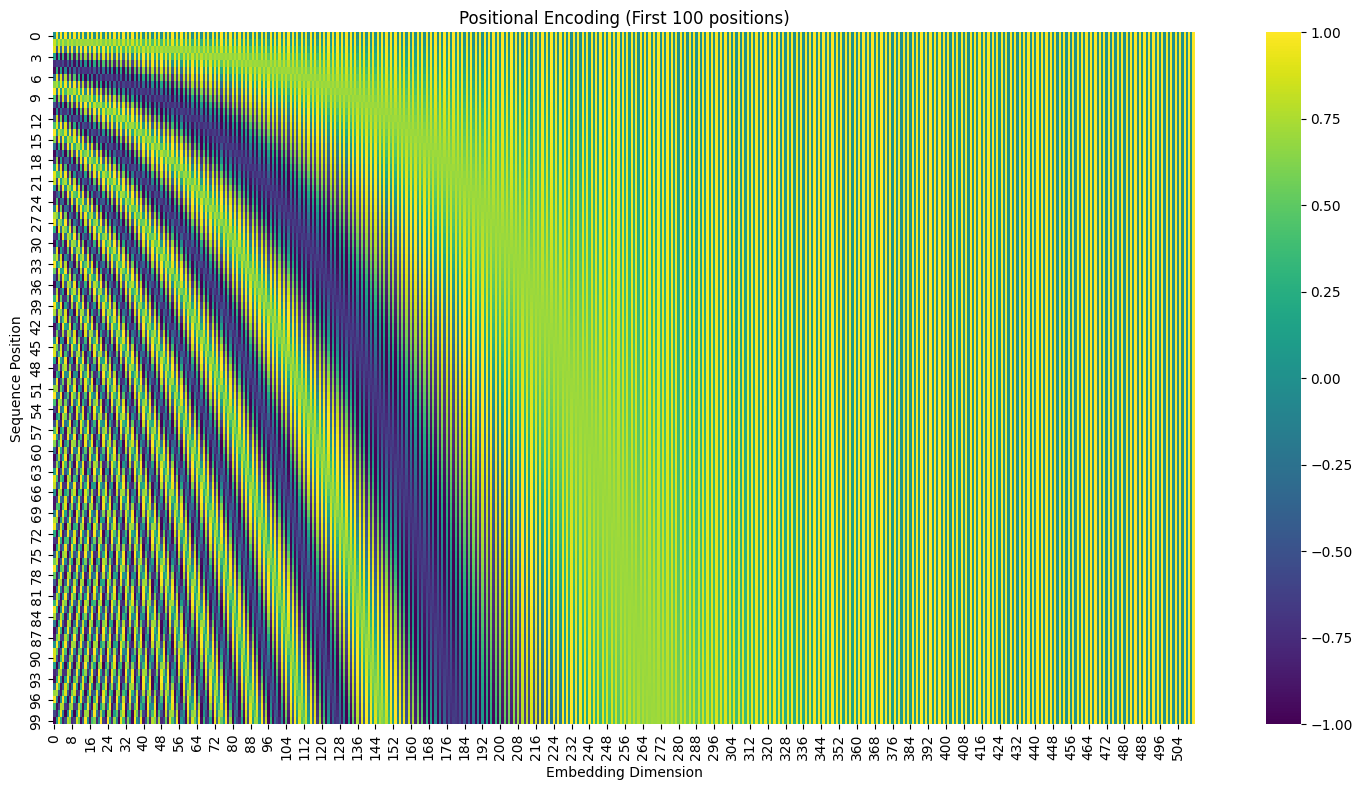

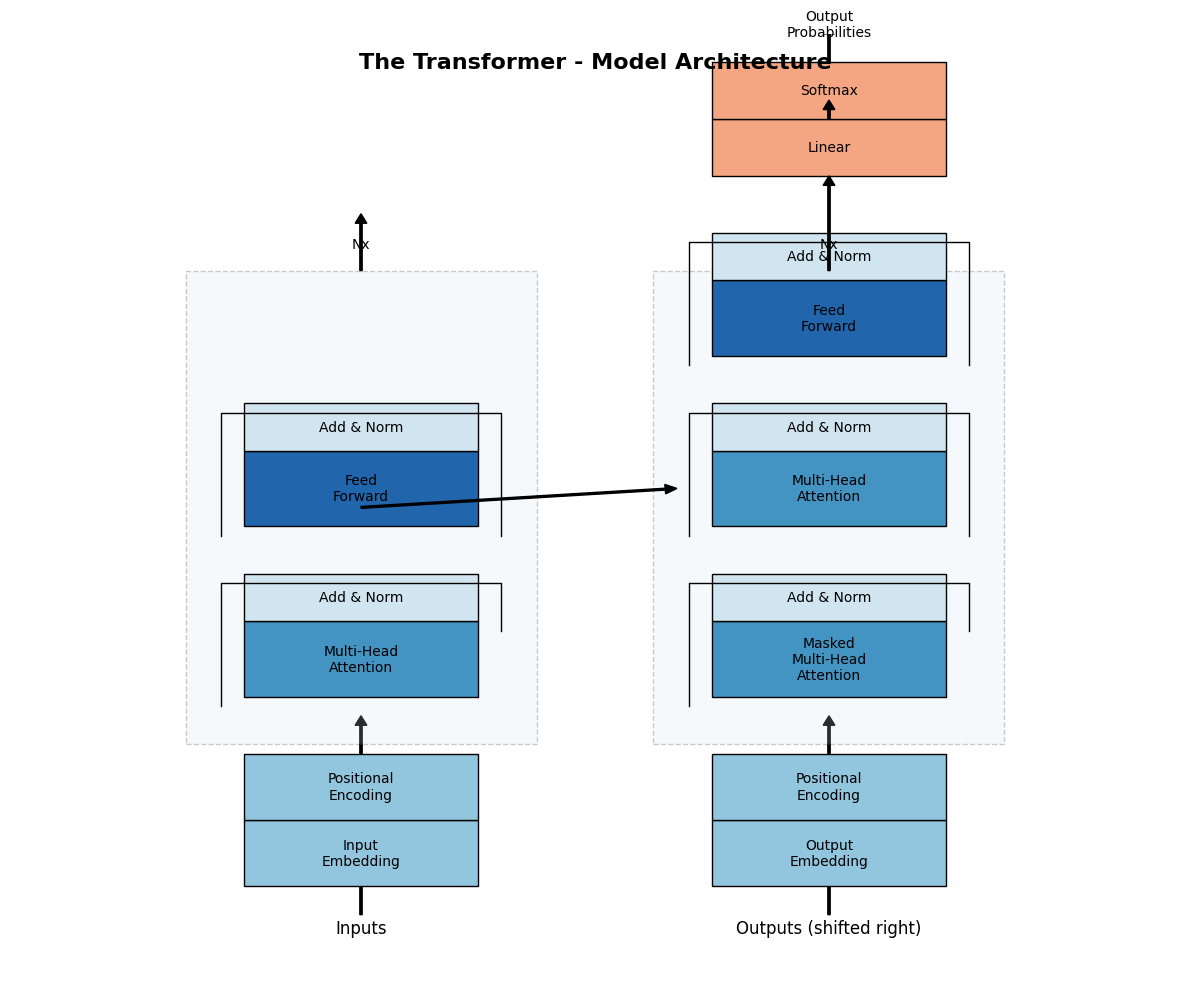

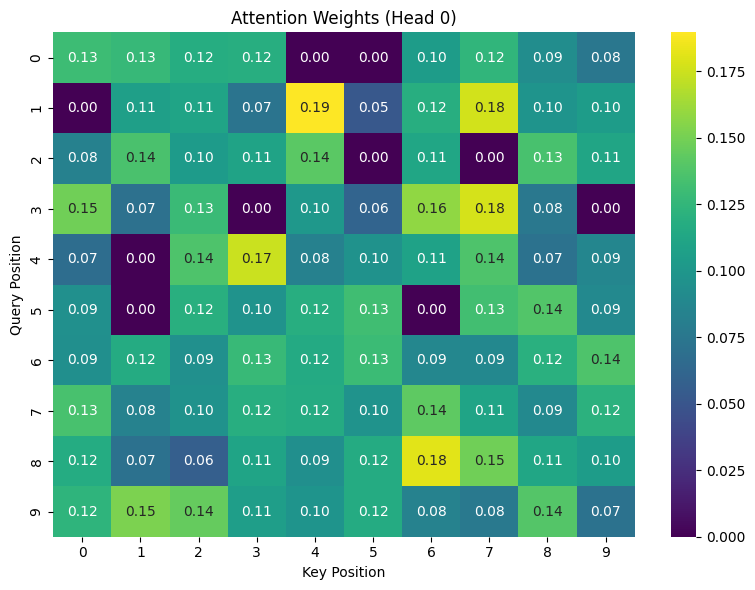

In [18]:
pe = PositionalEncoding(d_model=512)
pe.visualize()

visualize_transformer_architecture()

mha = MultiHeadAttention(h=8, d_model=512)
query = key = value = torch.randn(1, 10, 512)
mha(query, key, value)
mha.visualize_attention(head_idx=0)